In [ ]:
import sys, os

root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.append(root_path)

In [ ]:
from src.data.load_cifrar100 import *

train_loader, val_loader, test_loader = get_cifar100_dataloaders(
    batch_size=64,
    data_dir="./data/cifar100",
    num_workers=2,
    val_split=0.1,
    img_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


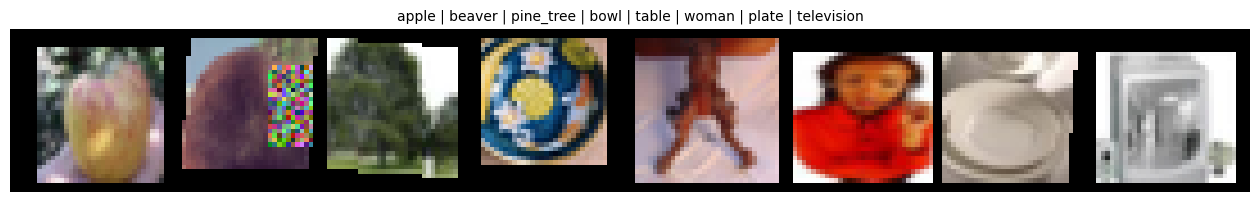

In [ ]:
from src.data.data_utils import *

cifar100_train = datasets.CIFAR100(
    root="./data/cifar100",
    train=True,
    download=False)

class_names = cifar100_train.classes
images, labels = next(iter(train_loader))
show_batch(images, labels, class_names=class_names, n=8)

---


In [ ]:
from stage_config import * 
from Model_A_OutGridNet import * 
from Model_B_OutGridNet import *

def cifar64_stages_t4_tinyplus(drop_path=0.08):
    # resoluciones: 64 -> 32 -> 16 -> 8
    return [
        StageCfg(dim=64,  depth=2, num_heads=2,  grid_size=8, outlook_heads=2,  drop_path=drop_path),
        StageCfg(dim=128, depth=2, num_heads=4,  grid_size=8, outlook_heads=4,  drop_path=drop_path),
        StageCfg(dim=256, depth=3, num_heads=8,  grid_size=4, outlook_heads=8,  drop_path=drop_path),
        StageCfg(dim=384, depth=1, num_heads=6,  grid_size=2, outlook_heads=6,  drop_path=drop_path)]

stages = cifar64_stages_t4_tinyplus()
model = OutlookerFrontGridNet(num_classes=100, stages=stages, stem_dim=64, outlooker_front_depth=3, dpr_max=0.1)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [44]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params = count_trainable_parameters(model)
print(f"Trainable parameters: {n_params:,}")

Trainable parameters: 12,266,266


In [ ]:
import random, numpy as np
from src.training.train_full_model import *

seed = 7
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history, model = train_model(
    model=model,
    train_loader=train_loader,
    epochs=50,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.0,

    print_every=100,
    save_path="best_maxout_medium.pt",
    last_path="last_maxout_medium.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.0,
    cutmix_alpha=1.0,

    num_classes=100,
    channels_last=True)

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=50 | steps/epoch=704 | total_steps=35200 | warmup_steps=1760
batch_size=64 | input_shape=(64, 3, 32, 32) | num_classes=100
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.0 | cutmix_alpha=1.0 | label_smoothing=0.0

=== Epoch 1/50 ===
[train step 100/704] loss 4.5838 | top1 2.02% | top3 5.58% | top5 8.81% | 257.6 img/s | lr 2.84e-05 | gnorm 5.982 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 200/704] loss 4.4982 | top1 3.07% | top3 7.79% | top5 12.09% | 295.7 img/s | lr 5.68e-05 | gnorm 5.716 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 300/704] loss 4.4169 | top1 4.05% | top3 9.98% | top5 14.98% | 310.4 img/s | lr 8.52e-05 | gnorm 5.535 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 400/704] loss 4.3643 | top1 4.83% | top3 11.59% | top5 17.12% | 317.3 img/s | lr 1.14e-04 | gnorm 5.336 | clip 100.0%

In [46]:
evaluate_one_epoch(model=model,dataloader=test_loader)

(0.8313404968261718, {'top1': 77.47, 'top3': 91.75, 'top5': 94.69})